In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [1]:
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
import joblib
import ast
import random
from sklearn.metrics import log_loss, brier_score_loss
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
import seaborn as sns


In [3]:
df=pd.read_csv('/content/gdrive/MyDrive/2025-2026/final_dataset.csv')

In [4]:
RND = 42

def majority_label(counts_str):
    d = ast.literal_eval(counts_str)
    return max(d.items(), key=lambda kv: kv[1])[0]

df['label'] = df['complexity_counts'].apply(majority_label)

In [5]:
all_tags = [
    'binary search', 'math', 'bitmasks', 'interactive',
    'constructive algorithms', 'hashing', 'dsu', 'dfs and similar', 'brute force', 'flows', 'sortings', 'strings',
    'two pointers', 'greedy', 'number theory', 'data structures', 'shortest paths',
    'meet-in-the-middle', '2-sat', 'geometry', 'combinatorics',
    'dp', 'implementation', 'graphs', 'trees', 'graph matchings', 'divide and conquer',
    'probabilities', 'expression parsing', 'games'
]

def parse_tags(s):
    s = s.strip()
    return [t.strip() for t in s.split(',') if t.strip()]

df['tags_list'] = df['tags'].apply(parse_tags)

mlb = MultiLabelBinarizer(classes=all_tags)
tags_m = mlb.fit_transform(df['tags_list'])

tags_df = pd.DataFrame(tags_m, columns=[f"tag_{t}" for t in mlb.classes_], index=df.index)

df = pd.concat([df, tags_df], axis=1)

In [6]:
feature_cols = [
    'time_limit', 'memory_limit', 'word_count', 'num_numbers', 'num_operations',
    'num_unique_variables', 'bin_1_26', 'bin_27_500', 'bin_501_5000', 'bin_5001_1e6', 'bin_large'
]
tag_cols = [c for c in df.columns if c.startswith('tag_')]
feature_cols += tag_cols

X = df[feature_cols].astype(float)
y = df['label'].astype(str)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=RND, stratify=y_encoded
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RND)

In [8]:
rf = RandomForestClassifier(random_state=RND, n_jobs=-1)
rf_param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2'],
    'class_weight': [None, 'balanced']
}

rf_gs = GridSearchCV(
    rf, rf_param_grid, cv=cv, scoring='f1_macro', n_jobs=-1, verbose=2
)
rf_gs.fit(X_train, y_train)
print("RF best params:", rf_gs.best_params_)
print("RF best CV (f1_macro):", rf_gs.best_score_)

best_rf = rf_gs.best_estimator_

Fitting 5 folds for each of 72 candidates, totalling 360 fits
RF best params: {'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 300}
RF best CV (f1_macro): 0.5208793882570534


In [9]:
xgb = XGBClassifier(objective='multi:softprob', use_label_encoder=False, eval_metric='mlogloss', random_state=RND, n_jobs=-1)
xgb_param_dist = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [1, 2, 5]
}
xgb_rs = RandomizedSearchCV(
    xgb, xgb_param_dist, n_iter=72, scoring='f1_macro', cv=cv, random_state=RND, n_jobs=-1, verbose=2
)
xgb_rs.fit(X_train, y_train)
print("XGB best params:", xgb_rs.best_params_)
print("XGB best CV (f1_macro):", xgb_rs.best_score_)

best_xgb = xgb_rs.best_estimator_

Fitting 5 folds for each of 72 candidates, totalling 360 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [19:20:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGB best params: {'subsample': 0.6, 'reg_lambda': 5, 'reg_alpha': 1, 'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.2, 'colsample_bytree': 0.6}
XGB best CV (f1_macro): 0.4572061738448293


=== RandomForest ===
Accuracy: 0.5667   Macro-F1: 0.5197
              precision    recall  f1-score   support

           0     0.4000    0.5000    0.4444         8
           1     0.8000    0.8000    0.8000         5
           2     0.5238    0.6111    0.5641        18
           3     0.0000    0.0000    0.0000         2
           4     0.5000    0.3636    0.4211        11
           5     0.8750    0.8750    0.8750         8
           6     0.5714    0.5000    0.5333         8

    accuracy                         0.5667        60
   macro avg     0.5243    0.5214    0.5197        60
weighted avg     0.5617    0.5667    0.5601        60





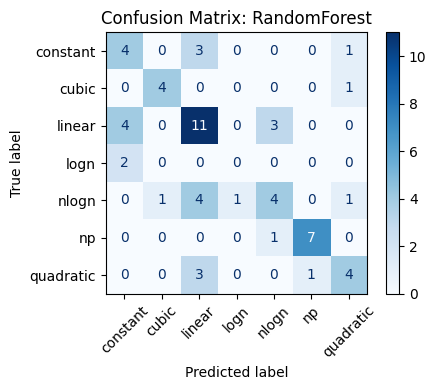



=== XGBoost ===
Accuracy: 0.5167   Macro-F1: 0.4215
              precision    recall  f1-score   support

           0     0.5714    0.5000    0.5333         8
           1     0.2500    0.2000    0.2222         5
           2     0.4800    0.6667    0.5581        18
           3     0.0000    0.0000    0.0000         2
           4     0.5000    0.4545    0.4762        11
           5     0.8750    0.8750    0.8750         8
           6     0.3333    0.2500    0.2857         8

    accuracy                         0.5167        60
   macro avg     0.4300    0.4209    0.4215        60
weighted avg     0.4938    0.5167    0.4991        60





/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


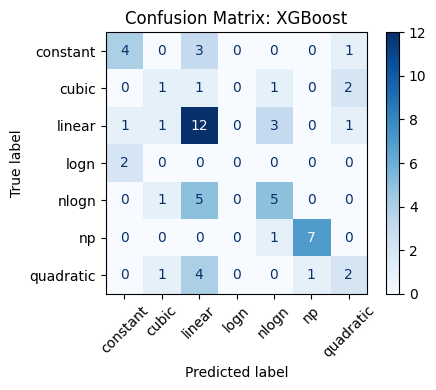

In [10]:
def eval_model(m, X_test, y_test, name="model"):
    preds = m.predict(X_test)
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average='macro')
    print(f"=== {name} ===")
    print(f"Accuracy: {acc:.4f}   Macro-F1: {f1:.4f}")
    print(classification_report(y_test, preds, digits=4))
    print("\n")

    fig, ax = plt.subplots(figsize=(5, 4))
    disp = ConfusionMatrixDisplay.from_predictions(
        y_test,
        preds,
        display_labels=le.classes_,
        cmap=plt.cm.Blues,
        xticks_rotation=45,
        ax=ax
    )
    ax.set_title(f"Confusion Matrix: {name}")
    plt.tight_layout()
    plt.show()

    print("\n")

    return {'accuracy': acc, 'f1_macro': f1}

rf_res = eval_model(best_rf, X_test, y_test, "RandomForest")
xgb_res = eval_model(best_xgb, X_test, y_test, "XGBoost")

In [11]:
joblib.dump(best_rf, "best_rf.joblib")
joblib.dump(best_xgb, "best_xgb.joblib")

['best_xgb.joblib']

In [12]:
importances_rf = pd.Series(best_rf.feature_importances_, index=X.columns).sort_values(ascending=False)
importances_xgb = pd.Series(best_xgb.feature_importances_, index=X.columns).sort_values(ascending=False)
print("RF importances:\n", importances_rf.head(20))
print("XGB importances:\n", importances_xgb.head(20))

RF importances:
 tag_bitmasks            0.102426
num_numbers             0.084473
word_count              0.082129
num_operations          0.071000
time_limit              0.060588
num_unique_variables    0.054861
tag_dp                  0.049971
tag_sortings            0.049015
tag_binary search       0.046474
bin_large               0.039527
tag_math                0.036951
bin_27_500              0.033994
tag_implementation      0.031075
tag_greedy              0.024753
bin_501_5000            0.024213
bin_5001_1e6            0.024142
tag_number theory       0.022208
bin_1_26                0.019886
tag_interactive         0.018600
tag_brute force         0.016018
dtype: float64
XGB importances:
 tag_bitmasks                   0.146243
tag_sortings                   0.088389
tag_shortest paths             0.044708
tag_probabilities              0.044116
tag_number theory              0.040875
tag_games                      0.039522
tag_binary search              0.037943
tag_dp    

In [13]:
perm = permutation_importance(best_xgb, X_test, y_test, scoring='f1_macro', n_repeats=10, random_state=RND, n_jobs=-1)
perm_imp = pd.Series(perm.importances_mean, index=X.columns).sort_values(ascending=False)
print("Permutation importances (XGB):\n", perm_imp.head(20))

Permutation importances (XGB):
 tag_bitmasks              0.095918
bin_27_500                0.049844
tag_implementation        0.049250
num_unique_variables      0.033434
time_limit                0.031672
tag_sortings              0.027098
tag_number theory         0.019587
tag_data structures       0.015785
bin_501_5000              0.014063
tag_trees                 0.012447
tag_math                  0.012090
bin_1_26                  0.008045
bin_5001_1e6              0.007948
word_count                0.001895
tag_binary search         0.000667
memory_limit              0.000000
tag_probabilities         0.000000
tag_expression parsing    0.000000
tag_meet-in-the-middle    0.000000
tag_graph matchings       0.000000
dtype: float64


In [14]:
perm_rf = permutation_importance(best_rf, X_test, y_test, scoring='f1_macro', n_repeats=10, random_state=RND, n_jobs=-1)

perm_importances_rf = pd.Series(perm_rf.importances_mean, index=X.columns).sort_values(ascending=False)
print("Permutation importances (Random Forest):\n", perm_importances_rf.head(20))

Permutation importances (Random Forest):
 tag_bitmasks                   0.163314
bin_27_500                     0.049943
tag_dp                         0.049460
tag_combinatorics              0.040690
word_count                     0.033106
time_limit                     0.023680
tag_sortings                   0.021278
num_numbers                    0.020034
tag_brute force                0.015598
tag_number theory              0.014536
bin_501_5000                   0.011382
tag_math                       0.008630
tag_constructive algorithms    0.006603
bin_5001_1e6                   0.003616
tag_flows                      0.000827
tag_strings                    0.000103
tag_graph matchings            0.000000
tag_expression parsing         0.000000
tag_divide and conquer         0.000000
tag_games                      0.000000
dtype: float64


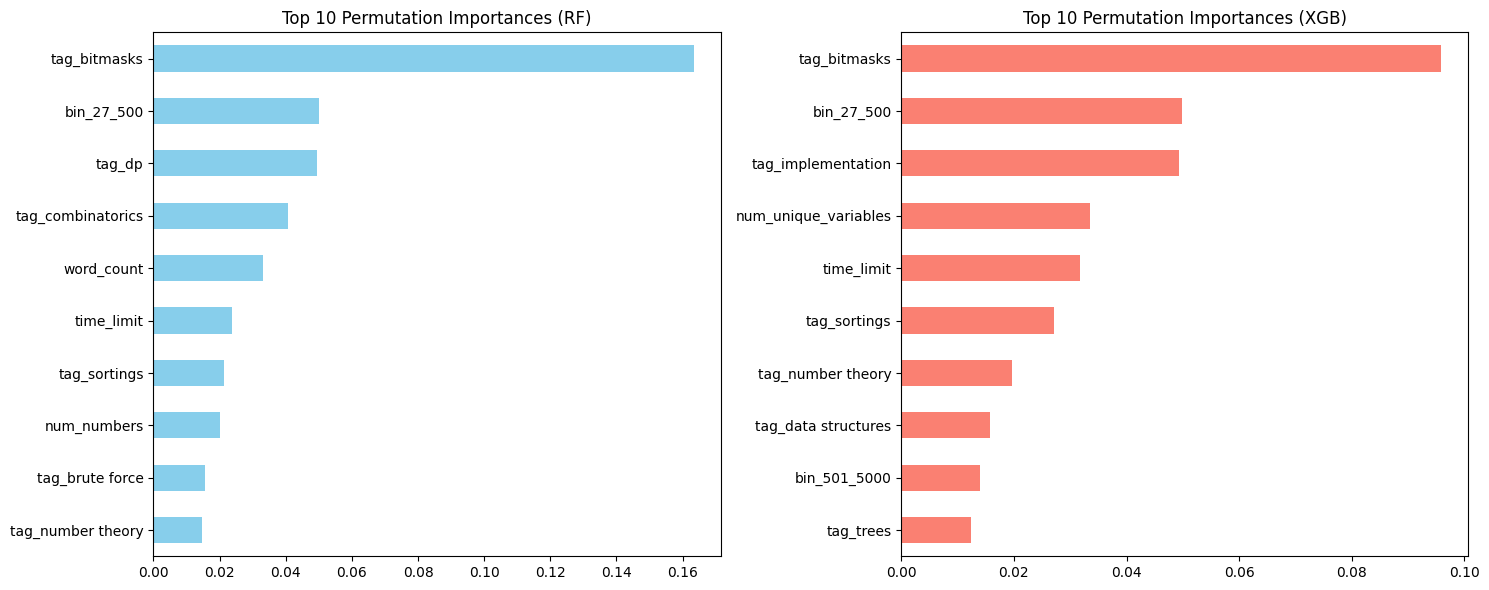

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

perm_importances_rf.head(10).plot(kind='barh', ax=ax1, color='skyblue')
ax1.set_title("Top 10 Permutation Importances (RF)")
ax1.invert_yaxis()

perm_imp.head(10).plot(kind='barh', ax=ax2, color='salmon')
ax2.set_title("Top 10 Permutation Importances (XGB)")
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

In [16]:
res_df = pd.DataFrame([{'model':'rf', **rf_res}, {'model':'xgb', **xgb_res}])
res_df.to_csv("model_comparison_results.csv", index=False)

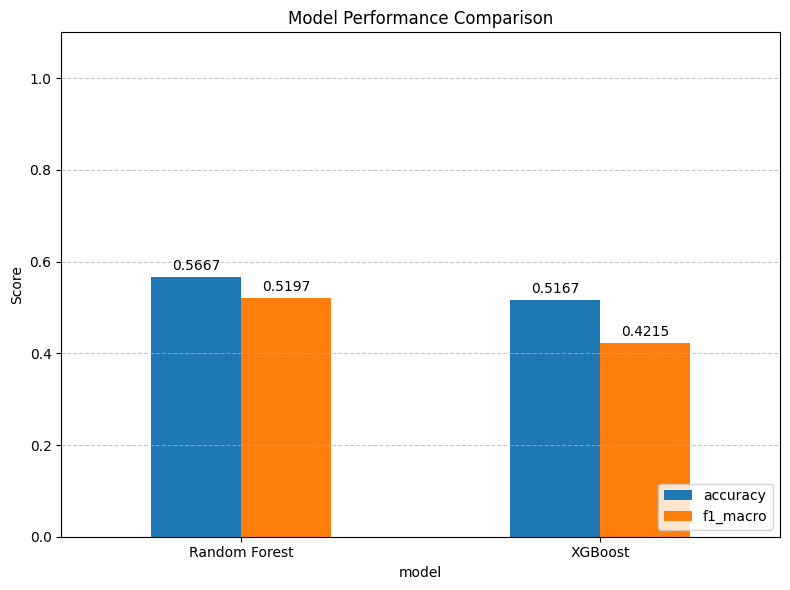

In [28]:
results_df = pd.DataFrame({
    'model': ['Random Forest', 'XGBoost'],
    'accuracy': [rf_res['accuracy'], xgb_res['accuracy']],
    'f1_macro': [rf_res['f1_macro'], xgb_res['f1_macro']]
})

ax = results_df.set_index('model').plot(kind='bar', figsize=(8, 6), rot=0)

for container in ax.containers:
    ax.bar_label(container, fmt='%.4f', padding=3)

plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

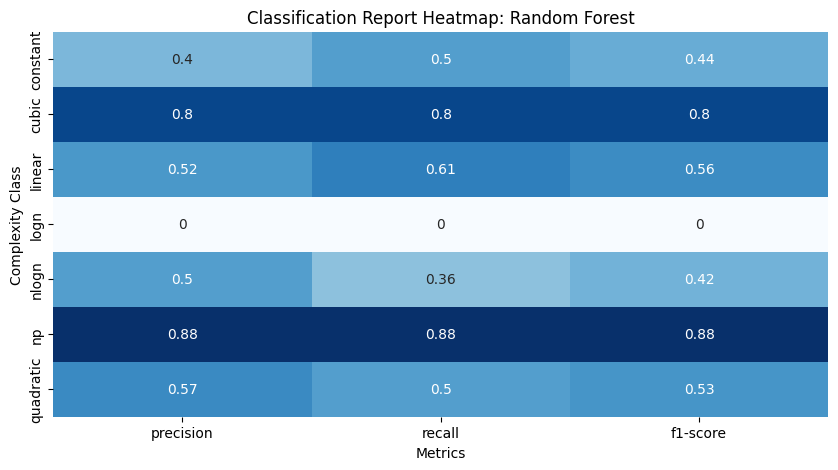

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


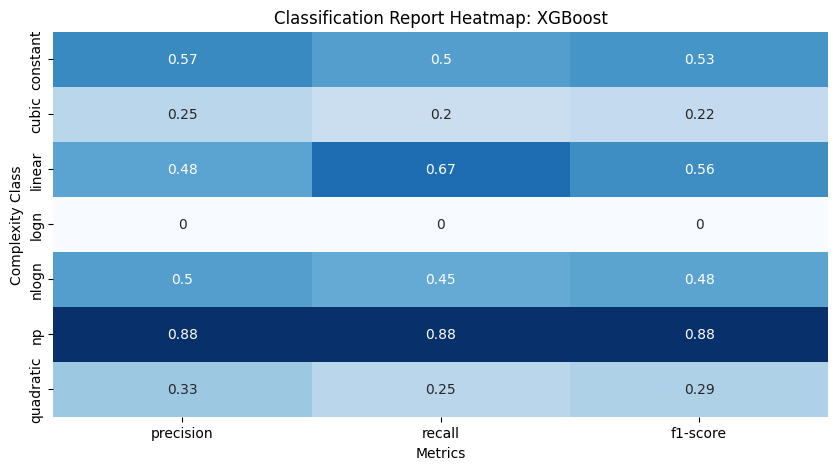

In [18]:
def plot_classification_report(y_true, y_pred, title):
    report = classification_report(y_true, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).iloc[:-1, :7].T
    report_df.index = le.classes_
    plt.figure(figsize=(10, 5))
    sns.heatmap(report_df, annot=True, cmap="Blues", cbar=False)
    plt.title(f"Classification Report Heatmap: {title}")
    plt.ylabel("Complexity Class")
    plt.xlabel("Metrics")
    plt.show()

plot_classification_report(y_test, best_rf.predict(X_test), "Random Forest")
plot_classification_report(y_test, best_xgb.predict(X_test), "XGBoost")

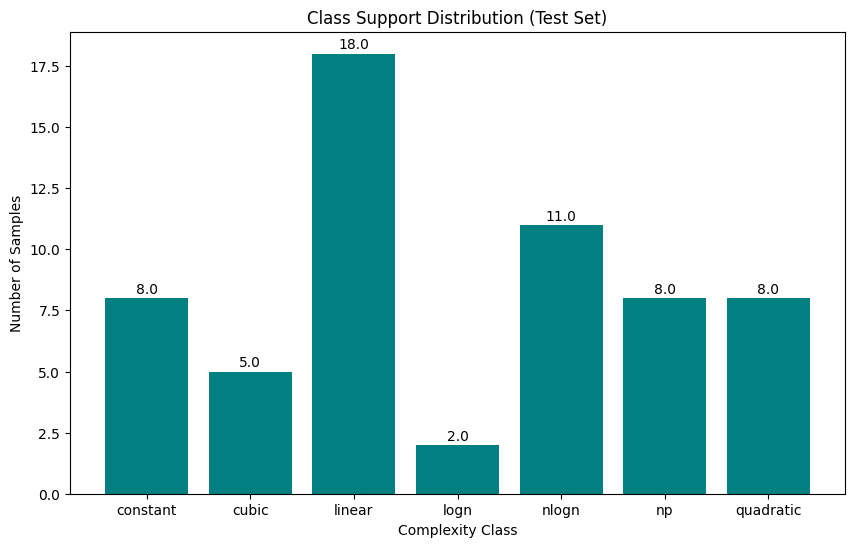

In [25]:
# Visualize support across classes
report = classification_report(y_test, best_rf.predict(X_test), output_dict=True)
class_names = le.classes_
support = [report[str(i)]['support'] for i in range(len(class_names))]

plt.figure(figsize=(10, 6))
plt.bar(class_names, support, color='teal')
plt.title("Class Support Distribution (Test Set)")
plt.xlabel("Complexity Class")
plt.ylabel("Number of Samples")
for i, v in enumerate(support):
    plt.text(i, v + 0.2, str(v), ha='center')
plt.show()